# HW1: Logistic Regression

This class is about models and algorithms for discrete data. This homework will have all 3 ingredients:
* **Data**: the results from all college football games in the 2023 season
* **Model**: The *Bradely-Terry* model for predicting the winners of football game. The Bradley-Terry model is just logistic regression.
* **Algorithm**: We will implement two ways of fitting logistic regression: gradient descent and Newton's method

## The Bradley-Terry Model

In the Bradley-Terry Model, we give team $k$ a team-effect $\beta_k$. Basically, higher $\beta_k$ (relatively speaking), means that team $k$ is a better team.
The Bradley-Terry model formalizes this intution by modeling the log odds of team $k$ beating team $k'$ by the difference in their team effects, $\beta_k - \beta_{k'}$.

Let $i = 1,\ldots, n$ index games, and let $h(i) \in \{1,\ldots,K\}$ and $a(i) \in \{1,\ldots,K\}$ denote the indices of the home and away teams, respectively.
Let $Y_i \in \{0,1\}$ denote whether the home team won.
Under the Bradley-Terry model,
\begin{equation*}
  Y_i \sim \mathrm{Bern}\big(\sigma(\beta_{h(i)} - \beta_{a(i)}) \big),
\end{equation*}
where $\sigma(\cdot)$ is the sigmoid function. We can view this model as a logistic regression model with covariates $x_i \in \mathbb{R}^K$ where,
\begin{align*}
x_{i,k} &=
\begin{cases}
+1 &\text{if } h(i) = k \\
-1 &\text{if } a(i) = k \\
0 &\text{o.w.},
\end{cases}
\end{align*}
and parameters $\beta \in \mathbb{R}^K$.

## Data

We use the results of college football games in the fall 2023 season, which are available from the course github page and loaded for you below.

The data comes as a list of the outcomes of individual games. You'll need to wrangle the data to get it into a format that you can feed into the Bradley-Terry model.

In [1]:
import torch
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
import numpy as np

In [2]:
allgames = pd.read_csv("https://raw.githubusercontent.com/slinderman/stats305b/winter2025/data/01_allgames.csv")

## Problem 0: Preprocessing

Preprocess the data to drop games with nan scores, construct the covariate matrix $X$, construct the response vector $y$, and do any other preprocessing you find useful.

**Pre-processing Logic**

I first drop all games with nan scores, and to avoid bias, further drop all the games where the points are tied, and drop all the games played in a neutral site.

Now, I consider the home team won if the home team had higher points in the game, and construct the response vector $y$.

To construct the covariate matrix $X$, notice that in the Bradley-Terry model, columns of $X$ represent the teams. In each row (which corresponds to a game), the value equals 1 if the team is the home team, equals -1 if the team is the away team, and equals 0 for all other teams.

In [3]:
# drop games with nan scores
# and store the results in a new dataframe called df
df = allgames.dropna(subset=['Home Points', 'Away Points', 'Neutral Site'])
# to avoid bias, further drop all the games where the points are tied.
df = df[df["Away Points"] != df["Home Points"]]
# to avoid bias, further drop all the games played at a neutral site
df = df[df["Neutral Site"] != True]

# Bradley-Terry model

# constructing the response vector y
points_difference = df["Home Points"] - df["Away Points"]
# consider the home team won if the home team had higher points in the game
y = (points_difference > 0)*1
# sort the teams (columns) alphabetically
teams = sorted(set(df["Away Team"]).union(set(df["Home Team"])))

# constructing the covariate matrix X
X_df = pd.DataFrame(0, index=df.index, columns=teams)
for i, game in df.iterrows():
  home_team = game["Home Team"]
  away_team = game["Away Team"]
  X_df.loc[i, home_team] = 1
  X_df.loc[i, away_team] = -1

# convert into tensors
y = torch.tensor(y.values, dtype=torch.float32).unsqueeze(1)
X = torch.tensor(X_df.values, dtype=torch.float32)
# checking shape
y.shape, X.shape

(torch.Size([3469, 1]), torch.Size([3469, 691]))

## Problem 1: Loss function

Write a function to compute the loss, $L(\beta)$ defined be

\begin{equation*}
  L(\beta) = -\frac{1}{n} \sum_{i=1}^n \log p(y_i \mid x_i; \beta) + \frac{\gamma}{2} \| \beta \|_2^2
\end{equation*}
where $\gamma$ is a hyperparameter that controls the strength of your $\ell_2$ regularization.

You may want to use the `torch.distributions.Bernoulli` class.

In [4]:
# loss function
def compute_loss(beta, X, y, gamma):
  average_log_likelihood = torch.distributions.Bernoulli(probs = torch.sigmoid(X @ beta)).log_prob(y).mean()
  loss = -1 * average_log_likelihood + gamma / 2 * (torch.norm(beta, 2) ** 2) # add l2 regularization
  return loss

## Problem 2: Gradient Descent

### Problem 2.1 Implementing and checking your gradients


Write a function to compute the gradient of the average negative log likelihood and check your output against the results obtained by PyTorch's automatic differentiation functionality.

**Answer:**

The gradient is computed as:
$$
\nabla L(\beta) = -\frac{1}{n} \sum_{i=1}^{n} \left[(y_i - \sigma(\beta^\intercal x_i)) x_i\right] + \gamma \beta
$$

Note that this is a vector with the same shape as $\beta$.

In [5]:
# gradient function
def compute_gradient(beta, X, y, gamma):
  grad_average_log_likelihood = -1/(y.shape[0]) * (X.T @ (y - torch.sigmoid(X @ beta)))
  grad_regularization = (gamma * beta)
  gradient = grad_average_log_likelihood + grad_regularization
  return gradient

In [6]:
# unit-testing
torch.manual_seed(0)
beta = torch.rand([X.shape[1],1], dtype=torch.float32, requires_grad=True)
gamma = 0.2

# auto-gradient
loss = compute_loss(beta, X, y, gamma)
loss.backward()
auto_gradient = beta.grad

# my computation
gradient = compute_gradient(beta, X, y, gamma)

# comparison
torch.allclose(gradient, auto_gradient)

True

### Problem 2.2: Implement Gradient Descent


Now, use gradient descent to fit your Bradley-Terry model to the provided data.

Deliverables for this question:
1. Code the implements gradient descent to fit your Bradley-Terry model to the provided data.
2. A plot of the loss curve of your algorithm and a brief discussion if it makes sense or not
3. A plot of the histogram of the fitted values of $\beta$
4. The top 10 teams from your ranking, and a discussion of whether this ranking makes sense or not.

**Answer 2.2**

First, a choice of the regularization hyperparameter $\gamma$. An optimal $\gamma$ can be chosen with cross validation. Please refer to Problem 4 for the code implementation. For Problem 2 - Problem 3, I set $\gamma = 0.01$.

Learning rate is also a hyperparameter. This can be set by looking at the convergence rate - but here I have set it arbitrarily for the sake of time. More details of this will be discussed in Problem 3 when gradient descent is compared against the Newton's method.

In [7]:
# gradient descent implementation code

# parameters

# learning rate
learning_rate = 2
# regularization parameter gamma
gamma = 0.01
# initial beta
beta = torch.zeros([X.shape[1],1], dtype=torch.float32, requires_grad=True)

# step update function in gradient descent
def gradient_descent_step(beta, learning_rate):
  #compute gradient
  current_gradient = compute_gradient(beta, X, y, gamma)
  next_beta = beta - learning_rate * current_gradient
  return next_beta

num_iterations = 1000
list_of_loss_gradient_descent = [compute_loss(beta, X, y, gamma)]
for _ in range(num_iterations):
  new_beta = gradient_descent_step(beta, learning_rate)
  list_of_loss_gradient_descent.append(compute_loss(new_beta, X, y, gamma))
  if torch.allclose(beta, new_beta, atol=1e-4):
    break
  else:
    beta = new_beta

Text(0, 0.5, 'loss')

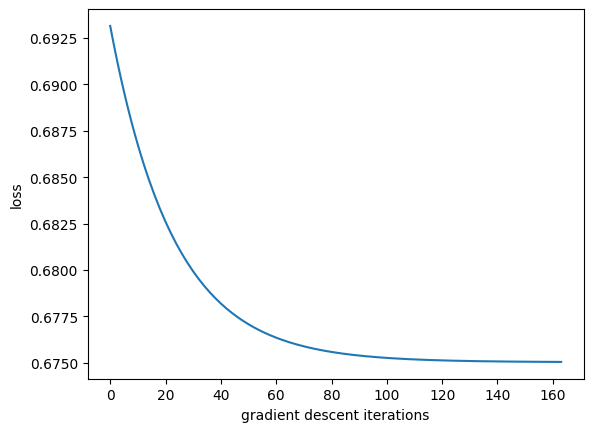

In [8]:
# plotting loss curve
loss_tensor_gradient_descent = torch.as_tensor(list_of_loss_gradient_descent)
plt.plot(loss_tensor_gradient_descent)
plt.xlabel("gradient descent iterations")
plt.ylabel("loss")

**Discussion of the plot:**

The above loss curve make sense - it is nicely shaped and the loss is going down and stablizing with each iteration.

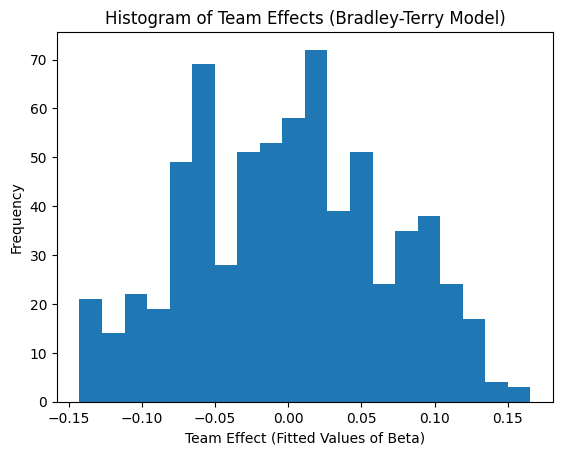

In [9]:
# plotting fitted values of beta
beta_df = pd.DataFrame({"Team": teams, "Effect": beta.detach().numpy().flatten()})

plt.hist(beta_df["Effect"], bins=20)
plt.title("Histogram of Team Effects (Bradley-Terry Model)")
plt.xlabel("Team Effect (Fitted Values of Beta)")
plt.ylabel("Frequency")
plt.show()

In [10]:
# top 10 teams
beta_df.sort_values(by="Effect", ascending=False).head(10)

,Team,Effect
303,Liberty,0.165334
631,Washington,0.155393
347,Michigan,0.154935
558,Texas,0.143481
214,Georgia,0.143417
129,Colorado Mines,0.143053
196,Florida State,0.141705
509,South Dakota State,0.131928
271,Johns Hopkins,0.131554
5,Alabama,0.130883


**Discussion of the Ranking:**

The ranking generally make sense as we can see tha the strongest teams (such as Washington and Michigan) ranked in the top. However, we also see a slight mixture of other teams - one wouldn't really expect teams such as Colorado Mines to have a stronger team effect that Alabama, or have Liberty ranked at the top.

The reason why this happens is due to the limitations of the data. In Bradley-Terry model, the team effects are calculated based solely on game win/lose track record, however, some teams may never play each other (especially across divisions). One probably hypothesis is that Colorado Mines is unbeatable in their own division, but the division itself is somewhat weaker than the division of Alabama, and the two teams never encountered each other in the historical games data. (Upon checking, indeed, Colorado Mines is a Division II team, while Alabama is a Division I team.)

## Problem 3: Newton's Method

Now, use Newton's method to fit your Bradley-Terry model to the provided data.


### Problem 3.1 The Hessian



#### Problem 3.1.1. Implement and check the Hessian
Write a function to compute the Hessian of the average negative log likelihood and check your answer against the output of `from torch.autograd.functional.hessian`.

**Answer**

Recall that the gradient is computed as:
$$
\nabla L(\beta) = -\frac{1}{n} \sum_{i=1}^{n} \left[(y_i - \sigma(\beta^\intercal x_i)) x_i\right] + \gamma \beta
$$

Hence, the Hessian is computed as:
$$
\nabla ^2 L(\beta) = \frac{1}{n} \sum_{i=1}^{n} \left[\sigma'(\beta^\intercal x_i)x_i x_i^\intercal \right] + \gamma \mathbf{I}_{\dim (\beta)}
$$

Note that $\sigma'(a) = \sigma(a)(1-\sigma(a))$. Thus, the Hessian can be further simplified into:
$$
\nabla ^2 L(\beta) = \frac{1}{n} \sum_{i=1}^{n} \left[\sigma(\beta^\intercal x_i)(1-\sigma(\beta^\intercal x_i))x_i x_i^\intercal \right] + \gamma \mathbf{I}_{\dim (\beta)}
$$

Let $w_i:= \sigma(\beta^\intercal x_i)(1-\sigma(\beta^\intercal x_i))$. Observe that this is the variance in the GLM model. We can thus write:

$$
\nabla ^2 L(\beta) = \frac{1}{n} \sum_{i=1}^{n} \left[w_i x_i x_i^\intercal \right] + \gamma \mathbf{I}_{\dim (\beta)} = \frac{1}{n} X^\intercal WX + \gamma \mathbf{I}_{\dim (\beta)}
$$

where $W_{ii} = w_i$, a diagonal matrix.

In [11]:
# hessian function
def compute_hessian(beta, X, y, gamma):
    y_hat = torch.sigmoid(X @ beta)
    W = torch.diag((y_hat * (1 - y_hat)).squeeze())
    hessian = (1 / y.shape[0]) * (X.T @ W @ X) + gamma * torch.eye(beta.shape[0])
    return hessian

In [12]:
# unit testing
torch.manual_seed(0)
beta = torch.rand([X.shape[1],1], dtype=torch.float32, requires_grad=True)
gamma = 0.2

# my computation
H = compute_hessian(beta, X, y, gamma)

# auto hessian
loss_helper = lambda beta: compute_loss(beta, X, y, gamma)
auto_H = torch.autograd.functional.hessian(loss_helper, beta).squeeze()

# comparison
print(torch.allclose(H, auto_H))

True


#### Problem 3.1.2: Positive definiteness

Compute the Hessian at the point $\beta = 0$ without regularization (set $\gamma = 0$). Unless you've done sort of pre-processing, it's probably singular.

In [13]:
# Answer 3.1.2
# Compute the Hessian at beta = 0 without regularization
beta_z = torch.zeros([X.shape[1],1], dtype=torch.float32, requires_grad=True)
gamma_z = 0
H_z = compute_hessian(beta_z, X, y, gamma_z)
#check if H_z is singular
print("rank: ", torch.linalg.matrix_rank(H_z))
print("determinant:", torch.linalg.det(H_z))

rank:  tensor(687)
determinant: tensor(-0., grad_fn=<LinalgDetBackward0>)


In [14]:
H_z.shape

torch.Size([691, 691])

Note the two outputs above. As $687<691$, $H_z$ is not full rank, i.e., the Hessian computed at $\beta = 0$ without regularization is singular. The check also also be seen from $\det(H_z) = 0$.

#### Problem 3.1.3

Describe intuitively and mathematically what it means for the Hessian of the negative log likelihood to be singular in the context of this data and model

**Answer 3.1.3**

Mathematically, Hessian of the negative log likelihood is singular means it is not full-rank, or equivalently, its determinant is zero. This may also indicate that the parameters are not uniquely estimable (global minimum is not unique).

Intuitively, in the context of our data and model, a singular Hessian indicates that some teams may not have sufficient track record, i.e. they do not play enough games with each other. More of this is explored in 3.1.4. Also, our Hessian is very sparse, which could also indicate singularity.

#### Problem 3.1.4

Give a hypothesis for why the Hessian in this dataset and model is singular, and provide empirical evidence to support your hypothesis.

**Answer 3.1.4**

Hypothesis: the Hessian of the negative log likelihood is singular is because the covariate matrix $X$ have linearly dependent columns, i.e., $X$ is not full column rank. Intuitively this means that not every team plays against each other. Mathematically this is also very probably because $X$ is very sparse by design.

In [15]:
# your code here

# checking the rank of X
print("rank of X: ", torch.linalg.matrix_rank(X))

rank of X:  tensor(687)


As seen above, $X$ is indeed not full column rank.

#### Problem 3.1.5

Explain why the Hessian is invertible when $\gamma > 0$.

**Answer 3.1.5**

Intuitively, this is GLM's analogy to the Ridge Regression model. In Ridge regression, by adding the regularization term $\gamma$, in the closed-form solution to the regression problem $(X^\intercal X + \gamma \mathbf{I})^{-1} X^\intercal y$, $X^\intercal X + \gamma \mathbf{I}$ is guaranteed to be invertible as the regularization part $\gamma \mathbf{I}$ forces the matrix to be full rank.

Mathematically, the analogy is also clear. Recall the definition of our computed Hessian:
$$
\nabla ^2 L(\beta) = \frac{1}{n} X^\intercal WX + \gamma \mathbf{I}_{\dim (\beta)}
$$
Whenever $\gamma >0$, the $\gamma \mathbf{I}_{\dim (\beta)}$ effectively forces the Hessian to be invertible by introducing regularization, making the Hessian full rank.

### Problem 3.2: Implement Newton's method

Now, use Newton's method to fit your $\ell_2$-regularized Bradley-Terry model to the provided data.

Deliverables for this question:
1. Code the implements Newton's method to fit your Bradley-Terry model to the provided data.
2. A plot of the loss curves from Newton's method and from gradient descent, using the same regularization strength $\gamma$ and initialization $\beta_0$. Briefly discuss the results and compare their rates of convergence.
3. A plot of the histogram of the fitted values of $\beta$
4. The top 10 teams from your ranking, and a discussion of whether this ranking makes sense or not.

In [16]:
# newton's method implementation code

# parameters

# learning rate
learning_rate = 0.1
# regularization parameter gamma
gamma = 0.01
# initial beta
beta = torch.zeros([X.shape[1],1], dtype=torch.float32, requires_grad=True)

def newton_step(beta, learning_rate):
  #compute gradient
  current_gradient = compute_gradient(beta, X, y, gamma)
  #compute hessian
  current_hessian = compute_hessian(beta, X, y, gamma)
  next_beta = beta - learning_rate * torch.linalg.inv(current_hessian) @ current_gradient
  return next_beta

num_iterations = 100
list_of_loss_newton = [compute_loss(beta, X, y, gamma)]
for _ in range(num_iterations):
  new_beta = newton_step(beta, learning_rate)
  list_of_loss_newton.append(compute_loss(new_beta, X, y, gamma))
  if torch.allclose(beta, new_beta, atol=1e-4):
    break
  else:
    beta = new_beta

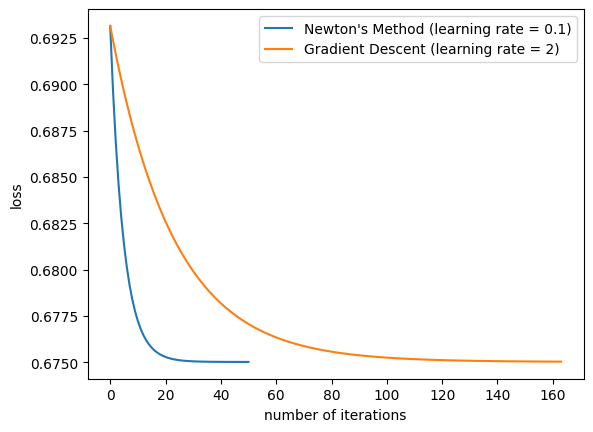

In [17]:
# plotting loss curve
list_of_loss_newton = torch.as_tensor(list_of_loss_newton)
plt.plot(list_of_loss_newton, label="Newton's Method (learning rate = 0.1)")
plt.plot(loss_tensor_gradient_descent, label="Gradient Descent (learning rate = 2)")
plt.xlabel("number of iterations")
plt.ylabel("loss")
plt.legend()

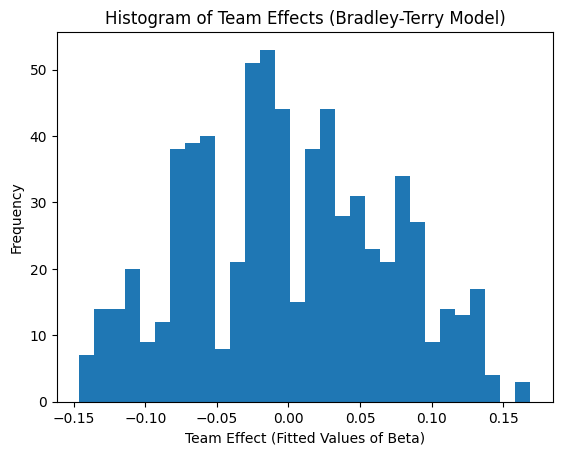

In [18]:
# plotting fitted values of beta
beta_df = pd.DataFrame({"Team": teams, "Effect": beta.detach().numpy().flatten()})

plt.hist(beta_df["Effect"], bins=30)
plt.title("Histogram of Team Effects (Bradley-Terry Model)")
plt.xlabel("Team Effect (Fitted Values of Beta)")
plt.ylabel("Frequency")
plt.show()

In [19]:
# top 10 teams
beta_df.sort_values(by="Effect", ascending=False).head(10)

,Team,Effect
303,Liberty,0.168954
631,Washington,0.159154
347,Michigan,0.158630
558,Texas,0.147077
214,Georgia,0.147008
129,Colorado Mines,0.146572
196,Florida State,0.145038
509,South Dakota State,0.135402
271,Johns Hopkins,0.134976
5,Alabama,0.134215


**Discussion of the plot and the ranking: Answer 3.2**

From the results above, especially the plot, we can see that the Newton's method converges way faster than gradient descent (in number of iterations), even if the learning rate is smaller. However, this comes at the cost of more computation time required in each step, because the Hessian needs to be computed in the Newton's method in each step.

In terms of the result, the rankings are similar for both methods (for top-ten, the rankings are the same), but for some reasons, the magnitude of team effects are somewhat different with the same regularization strength and initialization parameter. They are mostly similar!

## Problem 4: Model criticism and revision

Let's take another look the Bradley-Terry model from earlier and think about improvements we can make.


**Cross Validation and the Choice of Regularization Parameter**

The following code block is used to select the optimal regularization parameter.

In [20]:
# cross validation
from sklearn.model_selection import KFold

# accuracy score for cross-validation
def accuracy_score(X, y, beta):
    """
    Predict with logistic regression, compute classification accuracy.
    """
    with torch.no_grad():
        logits = X @ beta
         # note that the threshold is set at 0 <=> (p >= 0.5)
        preds = (logits >= 0).float()
        accurary = (preds == y).float().mean()
    return accurary.item()

# Newton's Method Training
def train_newton(X, y, gamma, num_iters=10, stepsize=0.1):
    beta = torch.zeros([X.shape[1],1], dtype=torch.float32)
    for iter in range(num_iters):
      grad = compute_gradient(beta, X, y, gamma)
      hess = compute_hessian(beta, X, y, gamma)
      new_beta = beta - stepsize * torch.linalg.inv(hess) @ grad
      if torch.allclose(beta, new_beta, atol=1e-4):
        break
      else:
        beta = new_beta
    return beta

def cross_validate_gamma(X, y, gammas, k=5):
    """
    Perform k-fold cross-validation over a set of gammas.
    Returns gamma that yields best average accuracy (or other metric).
    """
    kf = KFold(n_splits=k, shuffle=True, random_state=0)
    results = {}

    for gamma in gammas:
        fold_accuracies = []
        for train_index, val_index in kf.split(X):
            X_train, X_val = X[train_index], X[val_index]
            y_train, y_val = y[train_index], y[val_index]

            # Train model on training fold
            beta_cv = train_newton(X_train, y_train, gamma)

            # Evaluate on validation fold
            acc_val = accuracy_score(X_val, y_val, beta_cv)
            fold_accuracies.append(acc_val)

        # Store average CV accuracy for this gamma
        avg_acc = np.mean(fold_accuracies)
        results[gamma] = avg_acc
        print(f"Gamma={gamma}, Mean CV Accuracy={avg_acc:.4f}")

    # Pick gamma with highest average performance
    best_gamma = max(results, key=results.get)
    return best_gamma, results

gammas = [0.01, 0.1, 1, 10, 100]
cross_validate_gamma(X, y, gammas)

Gamma=0.01, Mean CV Accuracy=0.7290
Gamma=0.1, Mean CV Accuracy=0.7290
Gamma=1, Mean CV Accuracy=0.7287
Gamma=10, Mean CV Accuracy=0.5679
Gamma=100, Mean CV Accuracy=0.5679


(0.01,
 {0.01: 0.729028856754303,
  0.1: 0.729028856754303,
  1: 0.728740680217743,
  10: 0.567883026599884,
  100: 0.567883026599884})

### Problem 4.1: Improvements to Bradley-Terry Model
Choose one way to improve the Bradley-Terry model. Discuss *a priori* why you think this change will improve the model and implement your change.

**Answer 4.1**:

To improve analysis, there are multiple ways, including (1) re-investigating/refining model assumptions, (2) improve data quality, and (3) improve model architecture. I think the the model architecture is fairly robust, so the focus here in Q4 is on better understanding the data.  

One thing I noticed is that *the home team may have innate advantage as they are more familiar with the stadium.* They enjoy familiarity, more audience support (hence more morales), less travel time, etc. - all of these may factor into an innate home team advantage. However, note that some of the games are played at a neutral site, so there will be no home team advantage. I have already dropped those games at the beginning.

**Proposed Improvement:**

- run the Bradley-Terry model with one more covariate, `home_team_advantage`. The covariate `home_team_advantage` equals 1 for games played at the home stadium. For this processed dataset, this is equivalent to adding an intercept to the model.  

**A priori discussion:**
- Through this improvement, we can control for the home team advantage when estimating the team effects, which may allow for a more robust interpretation. (We do assume that the home team advantage is shared across all teams - this assumption may not be accurate. We will see how the model performs.)

**Implementation:**
The code below creates the new covariate and re-run the model using Newton's method.

In [21]:
# Implementation 4.1
# df["Neutral Site"].info() -- I have checked at there is no nan value
# constructing and concat the home_team_advantage column
df["home_team_advantage"] = 1 - df["Neutral Site"]*1
X_df_4 = pd.concat([df["home_team_advantage"], X_df], axis=1)
print(X_df_4.shape, X_df.shape)
X_4 = torch.tensor(X_df_4.values, dtype=torch.float32)

(3469, 692) (3469, 691)


In [22]:
# EDA - check this is the same as adding one intercept
print(X_df_4["home_team_advantage"].value_counts())

home_team_advantage
1    3469
Name: count, dtype: int64


In [23]:
# The regularization does not apply to the first column - think of it like an intercept.
# new loss
def compute_loss_4(beta, X, y, gamma):
  average_log_likelihood = torch.distributions.Bernoulli(probs = torch.sigmoid(X @ beta)).log_prob(y).mean()
  loss = -1 * average_log_likelihood + gamma / 2 * (torch.norm(beta[1:], 2) ** 2) # add l2 regularization but without the first column
  return loss

# new gradient function
def compute_gradient_4(beta, X, y, gamma):
  grad_average_log_likelihood = -1/(y.shape[0]) * (X.T @ (y - torch.sigmoid(X @ beta)))
  zero = torch.tensor([0.], dtype=beta.dtype, device=beta.device).unsqueeze(0)
  other = gamma * beta[1:]
  #print(zero.shape, other.shape)
  grad_regularization = torch.cat([zero, gamma * beta[1:]])
  gradient = grad_average_log_likelihood + grad_regularization
  return gradient

# new hessian function
def compute_hessian_4(beta, X, y, gamma):
    y_hat = torch.sigmoid(X @ beta)
    W = torch.diag((y_hat * (1 - y_hat)).squeeze())
    regularization_matrix = torch.diag(torch.cat([torch.tensor([0.], dtype=beta.dtype, device=beta.device),
                                                  gamma * torch.ones(beta.shape[0] - 1, dtype=beta.dtype, device=beta.device)]))
    hessian = (1 / y.shape[0]) * (X.T @ W @ X) + regularization_matrix
    return hessian

In [24]:
# Implementation with the new loss, gradient function, and hessian function

# learning rate
learning_rate = 0.2
# regularization parameter gamma
gamma = 0.01
# initial beta
beta_4 = torch.zeros([X_4.shape[1],1], dtype=torch.float32, requires_grad=True)

def newton_step_4(beta, learning_rate):
  #compute gradient
  current_gradient = compute_gradient_4(beta, X_4, y, gamma)
  #compute hessian
  current_hessian = compute_hessian_4(beta, X_4, y, gamma)
  next_beta = beta - learning_rate * torch.linalg.inv(current_hessian) @ current_gradient
  return next_beta

num_iterations = 100
list_of_loss_newton_4 = [compute_loss(beta_4, X_4, y, gamma)]
for _ in range(num_iterations):
  new_beta = newton_step_4(beta_4, learning_rate)
  list_of_loss_newton_4.append(compute_loss(new_beta, X_4, y, gamma))
  if torch.allclose(beta_4, new_beta, atol=1e-4):
    break
  else:
    beta_4 = new_beta

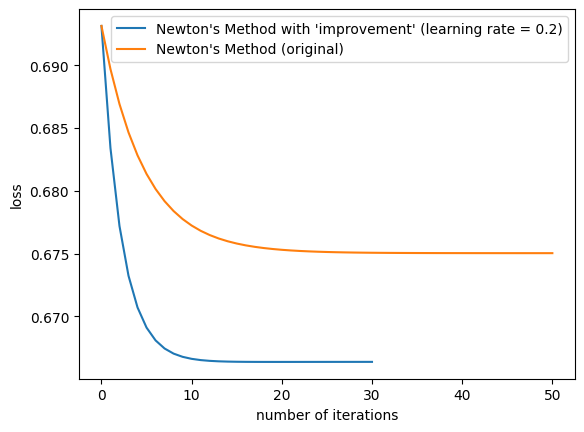

In [25]:
# plotting loss curve
list_of_loss_newton_4 = torch.as_tensor(list_of_loss_newton_4)
plt.plot(list_of_loss_newton_4, label="Newton's Method with 'improvement' (learning rate = 0.2)")
plt.plot(list_of_loss_newton, label="Newton's Method (original)")
#plt.plot(loss_tensor_gradient_descent, label="Gradient Descent (learning rate = 2)")
plt.xlabel("number of iterations")
plt.ylabel("loss")
plt.legend()

In [26]:
beta_df_4 = pd.DataFrame({"Team": teams, "Effect": beta_4[1:].detach().numpy().flatten()})
# top 10 teams
beta_df_4.sort_values(by="Effect", ascending=False).head(10)

,Team,Effect
303,Liberty,0.164734
631,Washington,0.156336
347,Michigan,0.155805
558,Texas,0.145837
129,Colorado Mines,0.145577
196,Florida State,0.143928
214,Georgia,0.142228
271,Johns Hopkins,0.135695
549,Susquehanna,0.134618
436,Ohio State,0.134184


*more details of the implementation are discussed in 4.2.*

### Problem 4.2: Evaluation
Assess whether or not your change was an improvement or not. Provide empirical evidence by evaluating performance on a held out test set and include at least one plot supporting your assessment.

**Answer 4.2**:

The following code implementation fulfills the evaluation by evaluating the model performance on a held out test set.

In [27]:
def accuracy_score(x, y, beta, alpha=0):
    """
    Predict with logistic regression, compute classification accuracy.
    """
    with torch.no_grad():
        logits = x.mv(beta) + alpha
        preds = (logits >= 0).float()  # threshold at 0 => p >= 0.5
        acc = (preds == y).float().mean()
    return acc.item()

# accuracy score for the test (held-out)
def accuracy_score(X, y, beta):
    """
    Predict with logistic regression, compute classification accuracy.
    """
    with torch.no_grad():
        logits = X @ beta
         # note that the threshold is set at 0 <=> (p >= 0.5)
        preds = (logits >= 0).float()
        accurary = (preds == y).float().mean()
    return accurary.item()

# Newton's Method Training - with improvement
def train_newton_4(X, y, gamma, num_iters=100, stepsize=0.1):
    # initializing the beta as zeros
    beta = torch.zeros([X.shape[1],1], dtype=torch.float32)
    list_of_loss = [compute_loss_4(beta, X, y, gamma)]
    for iter in range(num_iters):
      grad = compute_gradient_4(beta, X, y, gamma)
      hess = compute_hessian_4(beta, X, y, gamma)
      new_beta = beta - stepsize * torch.linalg.inv(hess) @ grad
      list_of_loss.append(compute_loss_4(new_beta, X, y, gamma))
      if torch.allclose(beta, new_beta, atol=1e-4):
        break
      else:
        beta = new_beta
    return beta, list_of_loss

# Newton's Method Training - original
def train_newton(X, y, gamma, num_iters=100, stepsize=0.1):
    # initializing the beta as zeros
    beta = torch.zeros([X.shape[1],1], dtype=torch.float32)
    list_of_loss = [compute_loss(beta, X, y, gamma)]
    for iter in range(num_iters):
      grad = compute_gradient(beta, X, y, gamma)
      hess = compute_hessian(beta, X, y, gamma)
      new_beta = beta - stepsize * torch.linalg.inv(hess) @ grad
      list_of_loss.append(compute_loss(new_beta, X, y, gamma))
      if torch.allclose(beta, new_beta, atol=1e-4):
        break
      else:
        beta = new_beta
    return beta, list_of_loss

# split into train/test to assess whether change was an improvement
from sklearn.model_selection import train_test_split
# getting the train test split for both X and X_4
X_train, X_test, y_train, y_test= train_test_split(
    X, y, test_size=0.3, random_state=0
)
X_4_train, X_4_test, y_train, y_test= train_test_split(
    X_4, y, test_size=0.3, random_state=0
)

original_beta, original_losses = train_newton(X_train, y_train, 0.01, num_iters=100, stepsize=0.1)
original_train_accuracy = accuracy_score(X_train, y_train, original_beta)
original_test_accuracy = accuracy_score(X_test, y_test, original_beta)
print(f"Original Model: \n Training Accuracy: {original_train_accuracy} \n Test Accuracy: {original_test_accuracy}")

improved_beta, improved_losses = train_newton_4(X_4_train, y_train, 0.01, num_iters=100, stepsize=0.1)
improved_train_accuracy = accuracy_score(X_4_train, y_train, improved_beta)
improved_test_accuracy = accuracy_score(X_4_test, y_test, improved_beta)
print(f"Improved Model: \n Training Accuracy: {improved_train_accuracy} \n Test Accuracy: {improved_test_accuracy}")

Original Model: 
 Training Accuracy: 0.8558484315872192 
 Test Accuracy: 0.7156580090522766
Improved Model: 
 Training Accuracy: 0.5733113884925842 
 Test Accuracy: 0.5850144028663635


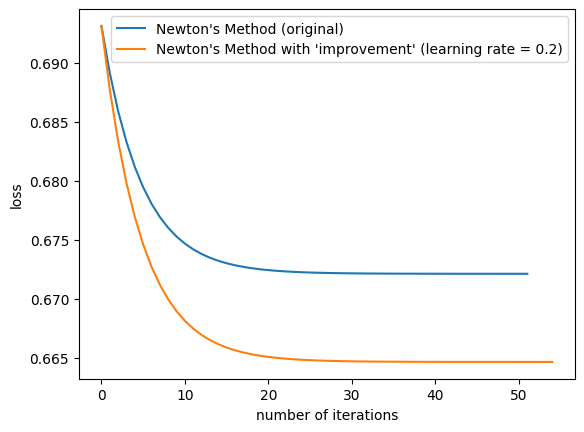

In [28]:
# plotting loss curve
plt.plot(torch.as_tensor(original_losses), label="Newton's Method (original)")
plt.plot(torch.as_tensor(improved_losses), label="Newton's Method with 'improvement' (learning rate = 0.2)")
plt.xlabel("number of iterations")
plt.ylabel("loss")
plt.legend()

**Interpretation and Discussion of the Experiment**

Good things:
- We are seeing a smaller loss with our experiment - adding the intercept (home team effect) does help with the loss. This can be seen from the plot above.

Bad things:
- The training accuracy decreased a lot, as well as the the test accuracy. (Note that it is kind of strange that the test accuracy is slightly better than the training accuracy in the experiment.)

### Problem 4.3: Reflection
Reflecting on the analysis we've conducted in this assignemnt, which conference is best? Is there a significant difference? Please justify your answer.

**Answer 4.3:** I will do this in four steps with justifications provided at the end.

In [29]:
# Step 1: mapping teams to their respective conferences
home_maps = df[['Home Team', 'Home Conference']].rename(columns={'Home Team': 'team', 'Home Conference': 'conference'})
away_maps = df[['Away Team', 'Away Conference']].rename(columns={'Away Team': 'team', 'Away Conference': 'conference'})
team_to_conference = pd.concat([home_maps, away_maps], ignore_index=True).drop_duplicates().set_index('team')['conference'].to_dict()
len(team_to_conference)

691

In [30]:
print(beta_df.shape)
beta_df.head()

(691, 2)


,Team,Effect
0,Abilene Christian,-0.014186
1,Adams State,-0.066825
2,Adrian,-0.106076
3,Air Force,0.053673
4,Akron,-0.106707


In [31]:
# Step 2: Make a list of betas in each conference
conference_betas = {}
for i, beta_info in beta_df.iterrows():
    team = beta_info['Team']
    beta = beta_info['Effect']
    conference = team_to_conference[team]
    if conference in conference_betas:
        conference_betas[conference].append(beta)
    else:
        conference_betas[conference] = [beta]

In [32]:
# Step 3: Which Conference is the Best? Looking at the mean
conference_means = {conference: np.mean(betas) for conference, betas in conference_betas.items()}
best_conference = max(conference_means, key=conference_means.get)
best_conference_mean = conference_means[best_conference]
print(f"The best conference is {best_conference} with a mean beta of {best_conference_mean:.4f}")

The best conference is SEC with a mean beta of 0.0329


In [33]:
# Step 4: Is the result significant? Run F-test
from scipy.stats import f_oneway

f_statistics, p_value = f_oneway(*list(conference_betas.values()))
print("F-statistic:", f_statistics)
print("p-value:", p_value)

F-statistic: 0.47459989629599325
p-value: 0.9999166783055502


As we can see from the test above, the differences are **not significant**.

**Justification of the answer**

F-test is used to determine whether there are significant differences between the means of two or more groups. The Null Hypothesis is that all group means are equal, and the Alternative Hypothesis is that at least one group's mean is different. In the analysis here, the p-value of the F-test is really really high - the F-test is not significant, so we fail to reject the Null Hypothesis, by concluding that there is no significant difference among group means. That is to say, the conclusion earlier that SEC is the best conference is not a statistically significant result.

## Submission Instructions

**Formatting:** check that your code does not exceed 80 characters in line width. You can set _Tools &rarr; Settings &rarr; Editor &rarr; Vertical ruler column_ to 80 to see when you've exceeded the limit.

**Converting to PDF** The simplest way to convert to PDF is to use the "Print to PDF" option in your browser. Just make sure that your code and plots aren't cut off, as it may not wrap lines.

**Alternatively** You can download your notebook in .ipynb format and use the following commands to convert it to PDF.  Then run the following command to convert to a PDF:
```
jupyter nbconvert --to pdf <yourlastname>_hw<number>.ipynb
```
(Note that for the above code to work, you need to rename your file `<yourlastname>_hw<number>.ipynb`)

**Installing nbconvert:**

If you're using Anaconda for package management,
```
conda install -c anaconda nbconvert
```

**Upload** your .pdf file to Gradescope. Please tag your questions correctly! I.e., for each question, all of and only the relevant sections are tagged.

Please post on Ed or come to OH if there are any other problems submitting the HW.